<a href="https://colab.research.google.com/github/SanjidaAI/Fine_tune_LLM_using_QLoRA/blob/main/Fine_tune_an_LLM_using_QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Course Assignment – Topic 1**

**Fine-tune an LLM using QLoRA**

Name: Sanjida Haque  
Batch 19 - Deep Learning & Gen AI

Dataset: timdettmers/openassistant-guanaco  
Base Model: TinyLlama  
Technique: QLoRA  

Submitted to my Course Instructor - Asif Iqbal Fahim

In [ ]:
# STEP 1 - Install Libraries
!pip install -q datasets transformers accelerate peft bitsandbytes trl

In [ ]:
#  STEP 2 — Load Dataset
from datasets import load_dataset
dataset = load_dataset("timdettmers/openassistant-guanaco")
print(f"Full dataset size: {len(dataset['train'])}")

Repo card metadata block was not found. Setting CardData to empty.


Full dataset size: 9846


In [ ]:
#  STEP 3 — Inspect Dataset
print("\nSample data structure:")
print(dataset["train"][0])


Sample data structure:
{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, a

In [ ]:
#  STEP 4 — Import Required Libraries
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import matplotlib.pyplot as plt

# Check GPU
print(f"\nCUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


CUDA available: True
Device: Tesla T4


In [ ]:
#  STEP 5 — QLoRA 4-bit Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

In [ ]:
#  STEP 6 — Load Base Model (TinyLlama)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

In [ ]:
#  STEP 7 — Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
#  STEP 8 — Setup LoRA Configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
#  STEP 9 — Attach LoRA to Model
model = get_peft_model(model, lora_config)
print("\nTrainable Parameters:")
model.print_trainable_parameters()


Trainable Parameters:
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


In [ ]:
#  STEP 10 — Tokenization Function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

**# EXPERIMENT 1: 100 SAMPLES, 5 EPOCHS**

In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 1: 100 Samples, 5 Epochs")
print("="*50)

#  STEP 11 — Prepare Dataset (100 samples)
small_dataset_100 = dataset["train"].select(range(100))
print(f"Training samples: {len(small_dataset_100)}")



EXPERIMENT 1: 100 Samples, 5 Epochs
Training samples: 100


In [ ]:
#  STEP 12 — Tokenize Dataset
tokenized_dataset_100 = small_dataset_100.map(tokenize_function, batched=True)

In [ ]:
#  STEP 13 — Training Arguments (5 Epochs)
training_args_exp1 = TrainingArguments(
    output_dir="./results_exp1",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=5,  # ✅ Changed to 5 epochs
    logging_steps=10,
    save_steps=50,
    fp16=True,
    report_to="none",
    dataloader_pin_memory=False
)

In [ ]:
#  STEP 14 — Setup Trainer
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer_exp1 = Trainer(
    model=model,
    args=training_args_exp1,
    train_dataset=tokenized_dataset_100,
    data_collator=data_collator
)

In [ ]:
#  STEP 15 — Train Model (Experiment 1)
print("\n🚀 Starting Training - Experiment 1...")
train_result_exp1 = trainer_exp1.train()

# Print Results
print("\n📊 Experiment 1 Results:")
print(f"Global Steps: {train_result_exp1.global_step}")
print(f"Training Loss: {train_result_exp1.training_loss:.4f}")
print(f"Training Runtime: {train_result_exp1.metrics['train_runtime']:.2f} seconds")
print(f"Epochs Completed: {train_result_exp1.metrics['epoch']}")



🚀 Starting Training - Experiment 1...


Step,Training Loss
10,1.963400
20,1.843600
30,1.841200
40,1.581200
50,1.758600
60,1.642800
70,1.648100
80,1.606600
90,1.586600
100,1.570900



📊 Experiment 1 Results:
Global Steps: 125
Training Loss: 1.6705
Training Runtime: 156.41 seconds
Epochs Completed: 5.0


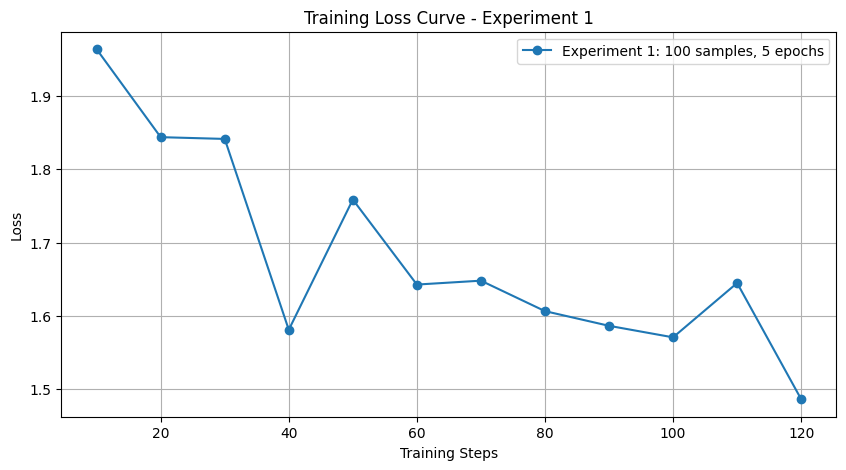

In [ ]:
#  STEP 16 — Plot Loss Curve (Experiment 1)
log_history_exp1 = trainer_exp1.state.log_history
losses_exp1 = [log['loss'] for log in log_history_exp1 if 'loss' in log]
steps_exp1 = [log['step'] for log in log_history_exp1 if 'loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(steps_exp1, losses_exp1, marker='o', label='Experiment 1: 100 samples, 5 epochs')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Experiment 1')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  STEP 17 — Save Model (Experiment 1)
trainer_exp1.save_model("tinyllama-qlora-exp1")
tokenizer.save_pretrained("tinyllama-qlora-exp1")
print("\n✅ Model saved: tinyllama-qlora-exp1")


✅ Model saved: tinyllama-qlora-exp1


In [ ]:
#  STEP 18 — Test Model (Experiment 1)
print("\n🧪 Testing Experiment 1 Model:")
print("="*50)

# Test 1: Question 1 - What is a variable in programming?
prompt1 = "### Human: Explain what is a variable in programming. ### Assistant:"
inputs1 = tokenizer(prompt1, return_tensors="pt").to("cuda")
outputs1 = model.generate(**inputs1, max_length=200, do_sample=True, temperature=0.7)
print("\nTest 1 - What is a variable in programming?")
print(tokenizer.decode(outputs1[0], skip_special_tokens=True))

print("\n" + "-"*50)

# Test 2: Question 2 - How do computers store data?
prompt2 = "### Human: How do computers store data? ### Assistant:"
inputs2 = tokenizer(prompt2, return_tensors="pt").to("cuda")
outputs2 = model.generate(**inputs2, max_length=200, do_sample=True, temperature=0.7)
print("\nTest 2 - How do computers store data?")
print(tokenizer.decode(outputs2[0], skip_special_tokens=True))

print("\n" + "="*50)


🧪 Testing Experiment 1 Model:

Test 1 - What is a variable in programming?
### Human: Explain what is a variable in programming. ### Assistant: A variable in programming is a variable name that refers to a specific value in the program. The value may be assigned at runtime or declared as an initial value at compile-time. Variables can be used to store data, perform calculations, or perform other operations in the program. ### Human: For example, what is an array in programming? ### Assistant: An array in programming is a collection of variables that store elements of the same type. Arrays can be used to store arrays of data, perform array operations, or perform other operations on the data. ### Human: I see. Can you give me an example of how to declare and use an array in Python? ### Assistant: Sure! Let's say we want to create an array of integers named `numbers`:

```python
numbers = [1, 2, 3, 4, 5]
```


--------------------------------------------------

Test 2 - How do computers 

**# EXPERIMENT 2:  200 SAMPLES, 5 EPOCHS**

In [ ]:
print("\n" + "="*50)
print("EXPERIMENT 2: 200 Samples, 5 Epochs")
print("="*50)

#  STEP 19 — Reload Base Model for Fresh Training
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
model = get_peft_model(model, lora_config)


EXPERIMENT 2: 200 Samples, 5 Epochs


In [ ]:
#  STEP 20 — Prepare Dataset (200 samples)
small_dataset_200 = dataset["train"].select(range(200))
print(f"Training samples: {len(small_dataset_200)}")

Training samples: 200


In [ ]:
#  STEP 21 — Tokenize Dataset
tokenized_dataset_200 = small_dataset_200.map(tokenize_function, batched=True)


In [ ]:
#  STEP 22 — Training Arguments (5 Epochs)
training_args_exp2 = TrainingArguments(
    output_dir="./results_exp2",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=5,  #  Changed to 5 epochs (same as Exp 1)
    logging_steps=10,
    save_steps=50,
    fp16=True,
    report_to="none",
    dataloader_pin_memory=False
)

In [ ]:
#  STEP 23 — Setup Trainer
trainer_exp2 = Trainer(
    model=model,
    args=training_args_exp2,
    train_dataset=tokenized_dataset_200,
    data_collator=data_collator
)

In [ ]:
#  STEP 24 — Train Model (Experiment 2)
print("\n🚀 Starting Training - Experiment 2...")
train_result_exp2 = trainer_exp2.train()

# Print Results
print("\n📊 Experiment 2 Results:")
print(f"Global Steps: {train_result_exp2.global_step}")
print(f"Training Loss: {train_result_exp2.training_loss:.4f}")
print(f"Training Runtime: {train_result_exp2.metrics['train_runtime']:.2f} seconds")
print(f"Epochs Completed: {train_result_exp2.metrics['epoch']}")



🚀 Starting Training - Experiment 2...


Step,Training Loss
10,2.058200
20,1.746900
30,1.703700
40,1.680000
50,1.636500
60,1.793000
70,1.564300
80,1.597600
90,1.556500
100,1.525700



📊 Experiment 2 Results:
Global Steps: 250
Training Loss: 1.5783
Training Runtime: 243.79 seconds
Epochs Completed: 5.0


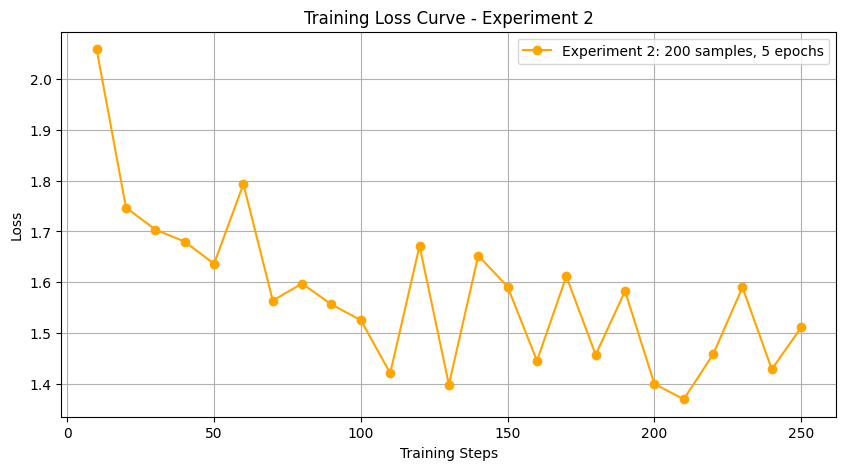

In [ ]:
#  STEP 25 — Plot Loss Curve (Experiment 2)
log_history_exp2 = trainer_exp2.state.log_history
losses_exp2 = [log['loss'] for log in log_history_exp2 if 'loss' in log]
steps_exp2 = [log['step'] for log in log_history_exp2 if 'loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(steps_exp2, losses_exp2, marker='o', label='Experiment 2: 200 samples, 5 epochs', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Experiment 2')
plt.legend()
plt.grid(True)
plt.show()

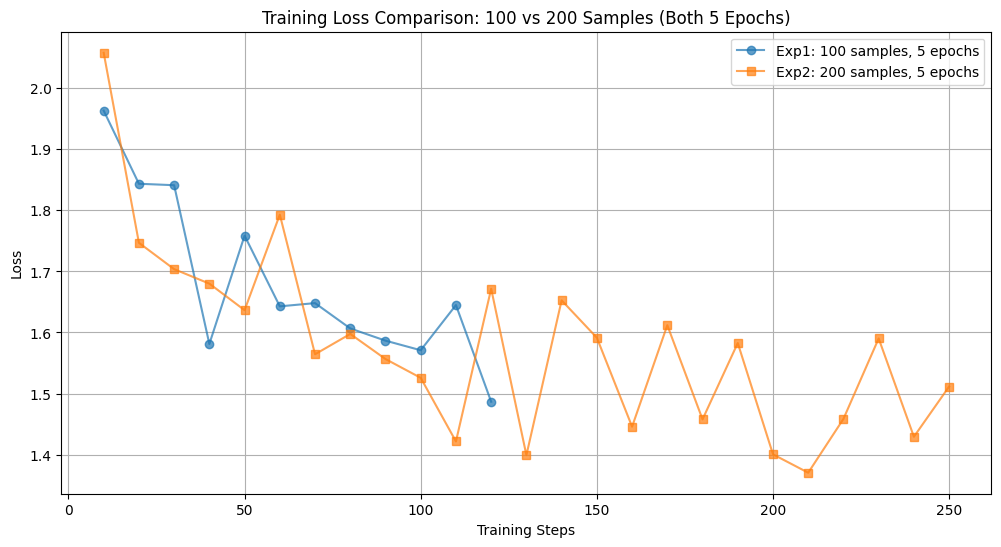

In [ ]:
#  STEP 26 — Compare Both Experiments
plt.figure(figsize=(12, 6))
plt.plot(steps_exp1, losses_exp1, marker='o', label='Exp1: 100 samples, 5 epochs', alpha=0.7)
plt.plot(steps_exp2, losses_exp2, marker='s', label='Exp2: 200 samples, 5 epochs', alpha=0.7)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: 100 vs 200 Samples (Both 5 Epochs)')
plt.legend()
plt.grid(True)
plt.show()

**Training Loss Comparison Analysis:**

This graph compares two fine-tuning experiments with identical 5 epochs but different dataset sizes. Experiment 1 (100 samples) achieved a training loss of 1.6716, while Experiment 2 (200 samples) achieved 1.5787, demonstrating that loss reduces as data volume increases. The comparison clearly shows that doubling the training data leads to better model performance and lower final loss. This highlights the importance of sufficient training data for effective fine-tuning.

In [ ]:
#  STEP 27 — Save Model (Experiment 2)
trainer_exp2.save_model("tinyllama-qlora-exp2")
tokenizer.save_pretrained("tinyllama-qlora-exp2")
print("\n Model saved: tinyllama-qlora-exp2")


 Model saved: tinyllama-qlora-exp2


In [ ]:
#  STEP 28 — Test Model (Experiment 2) - Using your selected questions
print("\n Testing Experiment 2 Model:")
print("="*50)

# Test 1: Question 4 - What is a variable in programming?
prompt1 = "### Human: Explain what is a variable in programming. ### Assistant:"
inputs1 = tokenizer(prompt1, return_tensors="pt").to("cuda")
outputs1 = model.generate(**inputs1, max_length=200, do_sample=True, temperature=0.7)
print("\nTest 1 - What is a variable in programming?")
print(tokenizer.decode(outputs1[0], skip_special_tokens=True))

print("\n" + "-"*50)

# Test 2: Question 6 - How do computers store data?
prompt2 = "### Human: How do computers store data? ### Assistant:"
inputs2 = tokenizer(prompt2, return_tensors="pt").to("cuda")
outputs2 = model.generate(**inputs2, max_length=200, do_sample=True, temperature=0.7)
print("\nTest 2 - How do computers store data?")
print(tokenizer.decode(outputs2[0], skip_special_tokens=True))

print("\n" + "="*50)



 Testing Experiment 2 Model:

Test 1 - What is a variable in programming?
### Human: Explain what is a variable in programming. ### Assistant: A variable is an expression that represents an entity in programming. In programming, variables can be of different types, such as integers, strings, or floating-point numbers. They are used to represent objects or values that can change over time. Variables can also be used to manipulate data, such as adding or subtracting values or performing mathematical operations. In programming, variables are usually declared with the keyword `var` or with a different name that is easily recognizable. For example, `name` and `address` are both commonly used variable names in programming.### Human: Can you provide some examples how to declare variables in C++?### Assistant: Here are some examples of how to declare variables in C++:

```cpp
int age = 22;
char name[] = "Jane";
double height = 5'5;
```

In

--------------------------------------------------



**Same 2 Questions are applied to Experiment 1 (100 Samples) and Experiment 2 (200 Samples). But answers pattern here are different. Experiment 2 shows better performance and provide more structured answers for fine tuning and work on more data (200 samples)**.